In [2]:
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# If we want to consider inf and -inf to be “NA” in computations, we can set 
pd.options.mode.use_inf_as_na = True

%matplotlib inline
%pylab inline

In [3]:
train_df = pd.read_csv('data/aps_failure_training_set.csv', skiprows=range(0, 20))
test_df = pd.read_csv('data/aps_failure_test_set.csv', skiprows=range(0, 20))

In [4]:
# replace classes neg to 0, pos to 1
# alternative index accesing train_df.iloc[:,0]
train_df['class'] = train_df['class'].str.replace('neg','0')
train_df['class'] = train_df['class'].str.replace('pos','1')
cols = train_df.columns
train_df[cols] = train_df[cols].apply(pd.to_numeric, errors='coerce')

test_df['class'] = test_df['class'].str.replace('neg','0')
test_df['class'] = test_df['class'].str.replace('pos','1')
cols = test_df.columns
test_df[cols] = test_df[cols].apply(pd.to_numeric, errors='coerce')

In [5]:
# split dataframe into two arrays
cols = train_df.columns.drop('class')
X_train = train_df[cols].values
X_test = test_df[cols].values

# labels
y_train = train_df['class'].values
y_test = test_df['class'].values

In [6]:
# Create our imputer to replace missing values with the mean e.g.
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html
# strategy = {mean, median, most_frequent}

imp_train = Imputer(missing_values='NaN', strategy='median', axis=0)
imp_train = imp_train.fit(X_train)
imp_test = Imputer(missing_values='NaN', strategy='median', axis=0)
imp_test = imp_test.fit(X_test)
# Impute each train and test item, then predict
X_train_imp = imp_train.transform(X_train)
X_test_imp = imp_test.transform(X_test)

### Estimate optimal number of features

In [35]:
from time import time
Cost_1 = 10 
Cost_2 = 500
columns = []
costs = []
times_reduce = []
times_train = []
times_pred = []
# _ , column = X_train.shape

column = 4
while column > 0:
    #     dimention reduction 
    t0 = time()
    X_train_new = SelectKBest(chi2, k=column).fit_transform(X_train_imp, y_train)
    X_test_new = SelectKBest(chi2, k=column).fit_transform(X_test_imp, y_test)
    times_reduce.append(round(time()-t0, 3))
    
    #     train model
    t1 = time()
    rfmodel = RandomForestClassifier(n_estimators=10)
    r_clf = rfmodel.fit(X_train_new, y_train)
    times_train.append(round(time()-t1, 3))

    #     test model
    t2 = time()
    y_pred = r_clf.predict(X_test_new)
    times_pred.append(round(time()-t2, 3))

    #     model evaluation
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    FP = cnf_matrix[0, 1]
    FN = cnf_matrix[1, 0]    
    Total_cost = (Cost_1*FP + Cost_2*FN)/len(y_pred)
    columns.append(column)
    costs.append(Total_cost)
    print("Total cost:", Total_cost, "Dimentions:", column, "Iter time:", round(time()-t0, 3), "s")
    column = column - 1

Total cost: 6.233125 Dimentions: 4 Iter time: 1.361 s
Total cost: 10.235 Dimentions: 3 Iter time: 0.84 s
Total cost: 11.21875 Dimentions: 2 Iter time: 0.726 s
Total cost: 11.35875 Dimentions: 1 Iter time: 0.259 s


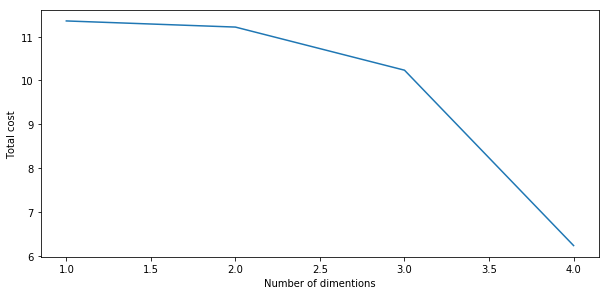

In [80]:
pylab.rcParams['figure.figsize'] = (10, 10)
ax = plt.subplot(211)
ax.plot(columns, costs)
plt.ylabel('Total cost')
plt.xlabel('Number of dimentions')
plt.show()

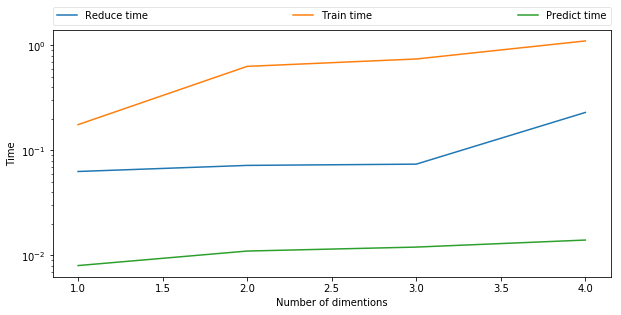

In [77]:
pylab.rcParams['figure.figsize'] = (10, 10)
ax = plt.subplot(211)
ax.plot(columns, times_reduce,  label="Reduce time")
ax.plot(columns, times_train, label="Train time")
ax.plot(columns, times_pred, label="Predict time")
ax.set_yscale('log')
leg = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
leg.get_frame().set_alpha(0.5)
plt.ylabel('Time')
plt.xlabel('Number of dimentions')
plt.show()

### Under-sampling


In [7]:
# from collections import Counter
# from imblearn.under_sampling import ClusterCentroids
# cc = ClusterCentroids(random_state=0)
# X_resampled, y_resampled = cc.fit_sample(X_train_imp, y_train)

### Random Forest Training
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [8]:
# train model
rfmodel = RandomForestClassifier(n_estimators=10)
r_clf = rfmodel.fit(X_train_imp, y_train)
y_pred = r_clf.predict(X_test_imp)

## Evaluation

In [9]:
acc = metrics.accuracy_score(y_pred, y_test)
print ("accuracy_score:", acc)

accuracy_score: 0.9686875


In [10]:
print('test labels: \n', pd.Series(y_test).value_counts())
print('predicted labels: \n', pd.Series(y_pred).value_counts())

test labels: 
 0    15625
1      375
dtype: int64
predicted labels: 
 0    15764
1      236
dtype: int64


In [11]:
# calculate null accuracy (for binary classification problems coded as 0/1)# calcul 
max(y_test.mean(), 1 - y_test.mean())

0.9765625

In [12]:
# how test and predicted labels look like 
print('True:', pd.Series(y_test).values[0:100])
print('Pred:', y_pred[0:100])

True: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Pred: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


#### Conclusion:
Classification accuracy is the easiest classification metric to understand<br>
But, it does not tell you the underlying distribution of response values<br>
And, it does not tell you what "types" of errors your classifier is making<br>

In [13]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# save confusion matrix and slice into four pieces
confusion = cnf_matrix
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(TP, TN, FP, FN)

55 15444 181 320


In [14]:
# Costs
# To minimize costs
Cost_1 = 10 
Cost_2 = 500
Total_cost = (Cost_1*FP + Cost_2*FN)/len(y_pred)

print("Total cost:", Total_cost)

Total cost: 10.113125


Confusion matrix, without normalization
[[15444   181]
 [  320    55]]
Normalized confusion matrix
[[0.99 0.01]
 [0.85 0.15]]


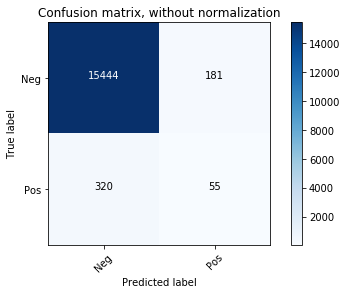

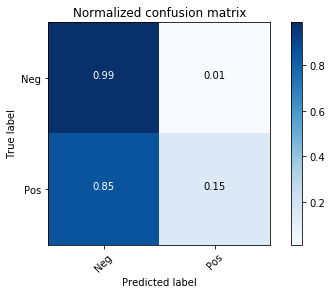

In [15]:
# Plot confusion matrix to evaluate the accuracy of a classification
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = (['Neg', 'Pos'])
   
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

+ Every observation in the testing set is represented in exactly one box
+ It's a 2x2 matrix because there are 2 response classes
+ The format shown here is not universal

Basic terminology <br>

+ True Positives (TP): we correctly predicted that there is some failure
+ True Negatives (TN): we correctly predicted that there is no failure
+ False Positives (FP): we incorrectly predicted that there is some failure (a "Type I error")
+ False Negatives (FN): we incorrectly predicted that there is no failure (a "Type II error")

## Metrics computed from a confusion matrix¶
#### Classification Accuracy: Overall, how often is the classifier correct?

In [16]:
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred))

0.9686875
0.9686875


#### Classification Error: Overall, how often is the classifier incorrect?

Also known as "Misclassification Rate"

In [17]:
print((FP + FN) / float(TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred))

0.0313125
0.031312499999999965


#### Sensitivity: When the actual value is positive, how often is the prediction correct?

How "sensitive" is the classifier to detecting positive instances?
Also known as "True Positive Rate" or "Recall"

In [18]:
print(TP / float(TP + FN))
print(metrics.recall_score(y_test, y_pred))

0.14666666666666667
0.14666666666666667


#### Specificity: When the actual value is negative, how often is the prediction correct?

+ How "specific" (or "selective") is the classifier in predicting positive instances?

In [19]:
print(TN / float(TN + FP))

0.988416


#### False Positive Rate: When the actual value is negative, how often is the prediction incorrect?

In [20]:
print(FP / float(TN + FP))

0.011584


#### Precision: When a positive value is predicted, how often is the prediction correct?

+ How "precise" is the classifier when predicting positive instances?

In [21]:
print(TP / float(TP + FP))
print(metrics.precision_score(y_test, y_pred))

0.2330508474576271
0.2330508474576271


#### Conclusion:

+ Confusion matrix gives you a more complete picture of how your classifier is performing
+ Also allows you to compute various classification metrics, and these metrics can guide your model selection

#### Which metrics should you focus on?

+ Choice of metric depends on your business objective
+ Spam filter (positive class is "spam"): Optimize for precision or specificity because false negatives (spam goes to + the inbox) are more acceptable than false positives (non-spam is caught by the spam filter)
+ Fraudulent transaction detector (positive class is "fraud"): Optimize for sensitivity because false positives (normal transactions that are flagged as possible fraud) are more acceptable than false negatives (fraudulent transactions that are not detected)